In [1]:
import numpy as np
import simulation

# Simulation parameters
N = 5  # Number of particles
timesteps = 10000  # Number of simulation time steps
dt = 1e-2  # Timestep
alpha = 0.15  # cubic coupling
beta = 0.15  # quartic coupling

# alpha in np.linspace(0, 0.6, 5)
# beta in np.linspace(0, 0.6, 5)

# qs, ps = simulation.integration(N, timesteps, dt, alpha, beta)

In [2]:
import os

folder_path = 'D:\School\Magistrska\data'  # Replace with the actual folder path

# List all files and directories in the specified folder
items = os.listdir(folder_path)

# Filter out only the files from the list
files = [item for item in items if os.path.isfile(os.path.join(folder_path, item))]

In [3]:
qs = np.empty((1, timesteps, N))
alpha_beta = np.empty((1, 2))

for file in files:
    data = np.load(folder_path+"\\"+file)
    qs = np.concatenate((qs, data[np.newaxis, 1:]), axis=0)
    alpha_beta = np.concatenate((alpha_beta, data[np.newaxis, 0, :2]), axis=0)
    
qs = qs[1:]
alpha_beta = alpha_beta[1:]

In [4]:
qs_mean = np.mean(qs)
qs_std = np.std(qs)

def preprocess(X):
  X = (X - qs_mean) / qs_std
  return X

def postprocess(X):
  X = X * qs_std + qs_mean
  return X

qs_mean, qs_std

(1.107230601718559e-05, 0.4437700430849304)

In [5]:
preprocess(qs)

def qs_to_X_y(data_qs, data_alpha_beta, window_size=5):
  X = []
  y = []
  for i in range(len(data_qs)):
    for j in range(len(data_qs[0]) - window_size):
      X.append(data_qs[i, j: j + window_size])
      y.append(data_alpha_beta[i])
      
  return np.array(X), np.array(y)

In [6]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

window_size = 200  # timesteps %= window_size = 0 has to hold
X, y = qs_to_X_y(qs, alpha_beta, window_size)

size = qs.shape[0] * (timesteps - window_size)

tr=int(size*train_size)
va=int(size*val_size)
te=int(size*test_size)

# Generate a random permutation
permutation = np.random.permutation(len(X))

# Shuffle both arrays using the same permutation
X = X[permutation]
y = y[permutation]

X_train, y_train = X[:tr], y[:tr]
X_val, y_val = X[-va:], y[-va:]
X_test, y_test = X[tr: tr +  te], y[tr: tr + te]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

model_lstm = Sequential()
model_lstm.add(InputLayer((window_size, N)))
# model_lstm.add(LSTM(64, return_sequences=True, activation= "tanh"))
model_lstm.add(LSTM(30, activation="tanh"))
# model_lstm.add(Dense(8, 'relu'))
model_lstm.add(Dense(2, 'linear'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                4320      
_________________________________________________________________
dense (Dense)                (None, 2)                 62        
Total params: 4,382
Trainable params: 4,382
Non-trainable params: 0
_________________________________________________________________


In [8]:
cp = ModelCheckpoint('model_lstm/', save_best_only=True)
model_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [9]:
epochs = 10
batchsize = 256

model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batchsize, callbacks=[cp], verbose = 2, workers=-2, use_multiprocessing=True)
from tensorflow.keras.models import load_model
model_lstm = load_model('model_lstm/')

Epoch 1/10
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_lstm\assets
575/575 - 167s - loss: 0.0459 - root_mean_squared_error: 0.2144 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
Epoch 2/10
INFO:tensorflow:Assets written to: model_lstm\assets
575/575 - 176s - loss: 0.0451 - root_mean_squared_error: 0.2124 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2119
Epoch 3/10
575/575 - 175s - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2122
Epoch 4/10
575/575 - 182s - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
Epoch 5/10
INFO:tensorflow:Assets written to: model_lstm\assets
575/575 - 210s - loss: 0.0450 - root_mean_squared_error: 0.2121 - va

In [10]:
test_pred_lstm = model_lstm.predict(X_test)

In [11]:
abs = np.linspace(0, 0.6, 5)
indices = []

for alpha in abs:
    for beta in abs:
        current_indices = np.where(np.all(y_test == [alpha, beta], axis=1))[0]
        indices.append([alpha, beta, current_indices])

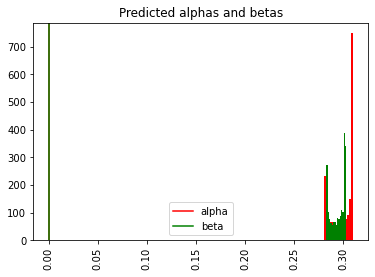

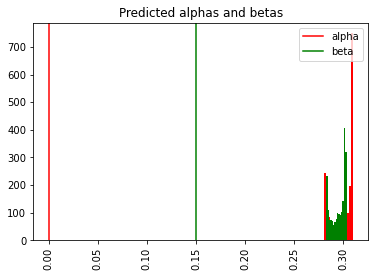

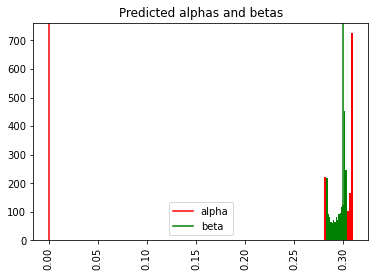

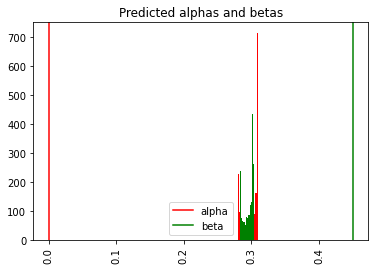

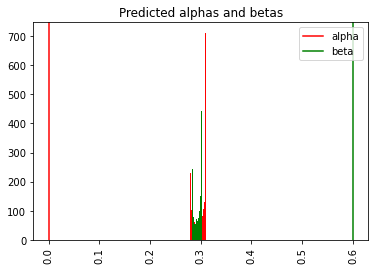

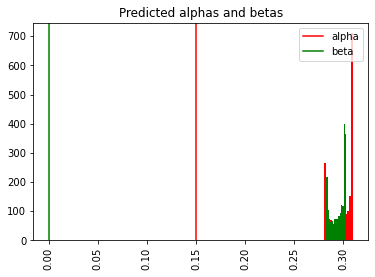

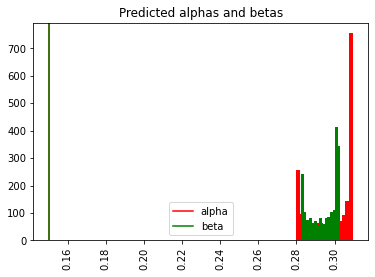

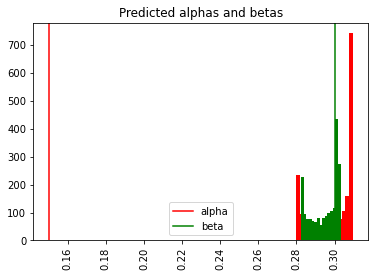

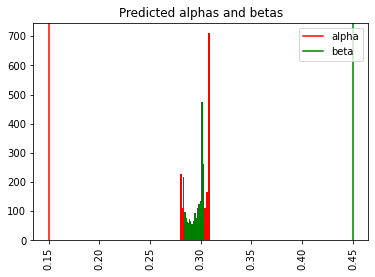

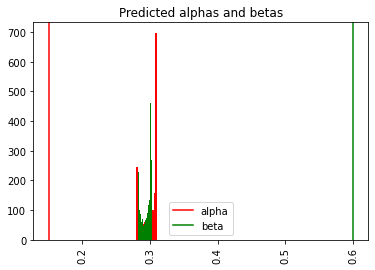

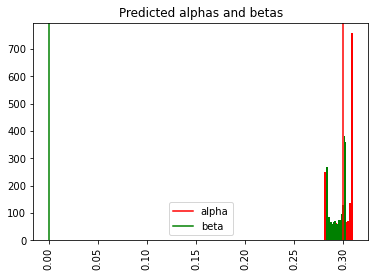

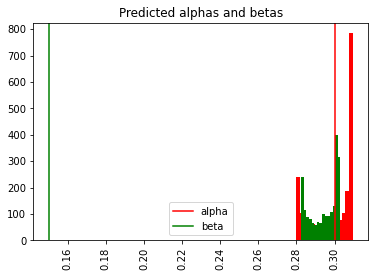

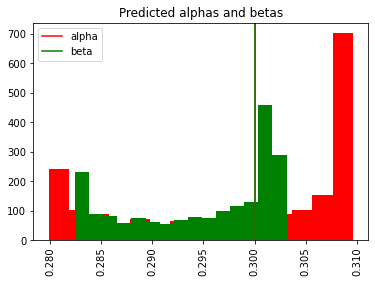

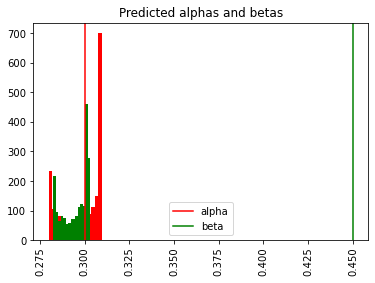

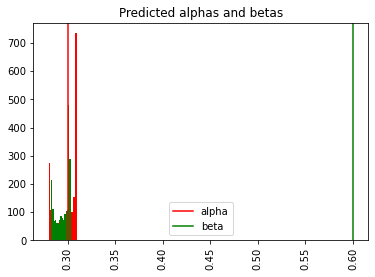

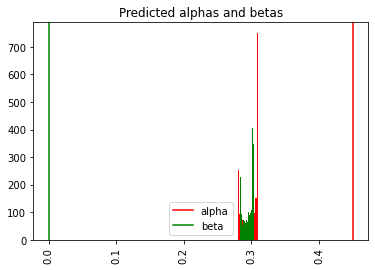

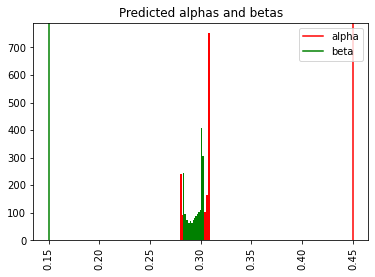

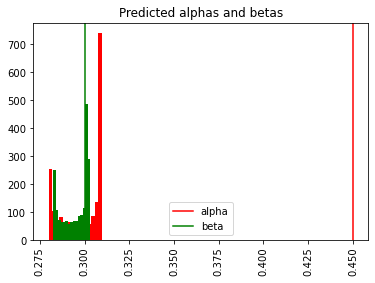

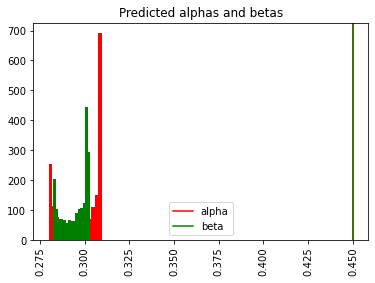

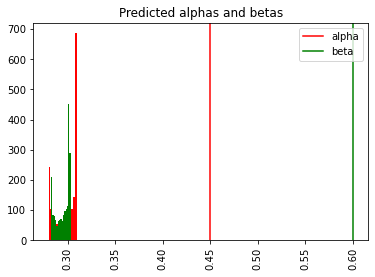

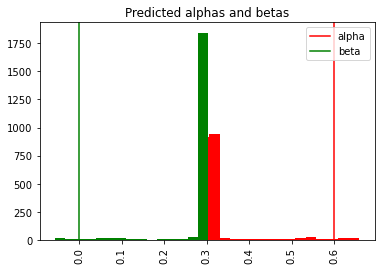

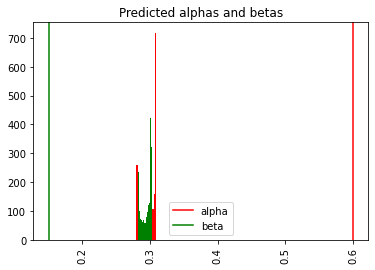

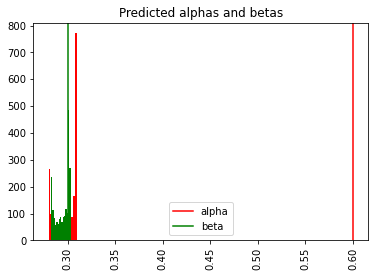

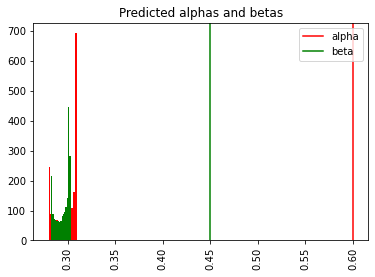

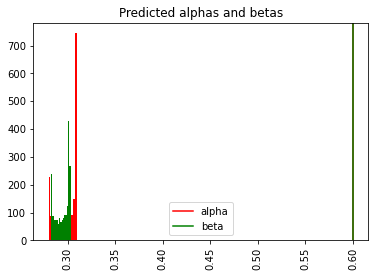

In [12]:
import matplotlib.pyplot as plt

for idx in indices:
    # Plot the histogram
    plt.hist(test_pred_lstm[idx[2], 0], bins=15, color='r')
    plt.hist(test_pred_lstm[idx[2], 1], bins=15, color='g')

    # Add a vertical line
    plt.axvline(x=idx[0], color='r', label='alpha')
    plt.axvline(x=idx[1], color='g', label='beta')

    # Add labels and title
    plt.title("Predicted alphas and betas")
    plt.xticks(rotation=90)

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()
